# Getting Started with AutoProf

In this notebook you will walk through the very basics of AutoProf functionality. Here you will learn how to make models; how to set them up for fitting; and how to view the results. These core elements will come up every time you use AutoProf, though in future notebooks you will learn how to take advantage of the advanced features in AutoProf.

In [1]:
import os
import autoprof as ap
import numpy as np
import torch
from astropy.io import fits
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

## Your first model

The basic format for making an AutoProf model is given below. Once a model object is constructed, it can be manipulated and updated in various ways.

In [2]:
model1 = ap.models.AutoProf_Model(
    name = "model1", # every model must have a unique name
    model_type = "sersic galaxy model", # this specifies the kind of model
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "n": 2, "Re": 10, "Ie": 1}, # here we set initial values for each parameter
    target = ap.image.Target_Image(np.zeros((100,100)), pixelscale = 1), # every model needs a target, more on this later
)
model1.initialize() # before using the model it is good practice to call initialize so the model can get itself ready

# We can print the model's basic info
print(model1)

name: model1
model_type: sersic galaxy model
window: {'origin': (0.0, 0.0), 'shape': (100.0, 100.0)}
parameters: {'center': {'name': 'center', 'value': [50.0, 50.0], 'units': 'arcsec', 'uncertainty': 0.1}, 'q': {'name': 'q', 'value': 0.6, 'units': 'b/a', 'uncertainty': 0.03, 'limits': (0, 1)}, 'PA': {'name': 'PA', 'value': 1.0471975803375244, 'units': 'radians', 'uncertainty': 0.06, 'limits': (0, 3.141592653589793), 'cyclic': True}, 'n': {'name': 'n', 'value': 2.0, 'units': 'none', 'uncertainty': 0.05, 'limits': (0.36, 8)}, 'Re': {'name': 'Re', 'value': 10.0, 'units': 'arcsec', 'limits': (0, None)}, 'Ie': {'name': 'Ie', 'value': 1.0, 'units': 'log10(flux/arcsec^2)'}}



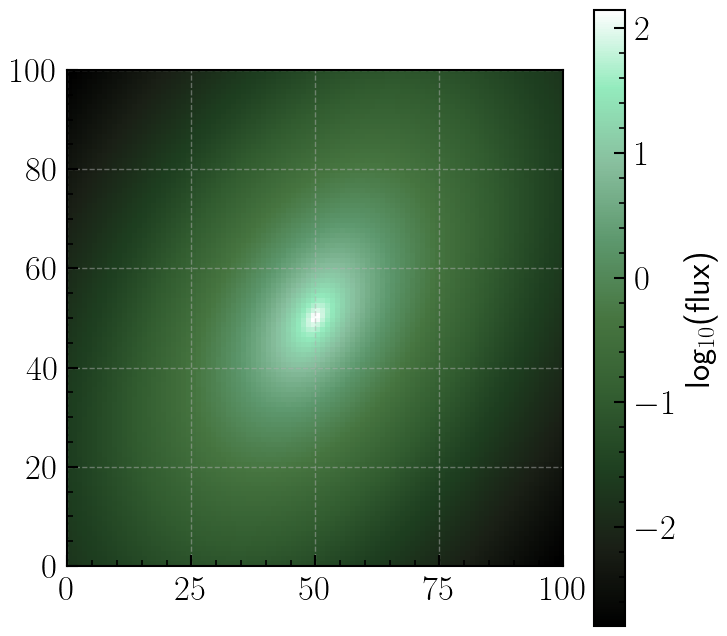

In [3]:
# AutoProf has built in methods to plot relevant information. We didn't specify the region on the sky for
# this model to focus on, so we just made a 100x100 window. Unless you are very lucky this wont
# line up with what you're trying to fit, so next we'll see how to give the model a target.

fig, ax = plt.subplots(figsize = (8,8))
ap.plots.model_image(fig, ax, model1)
plt.show()

## Giving the model a Target

Typically, the main goal when constructing an AutoProf model is to fit to an image. We need to give the model access to the image and some information about it to get started.

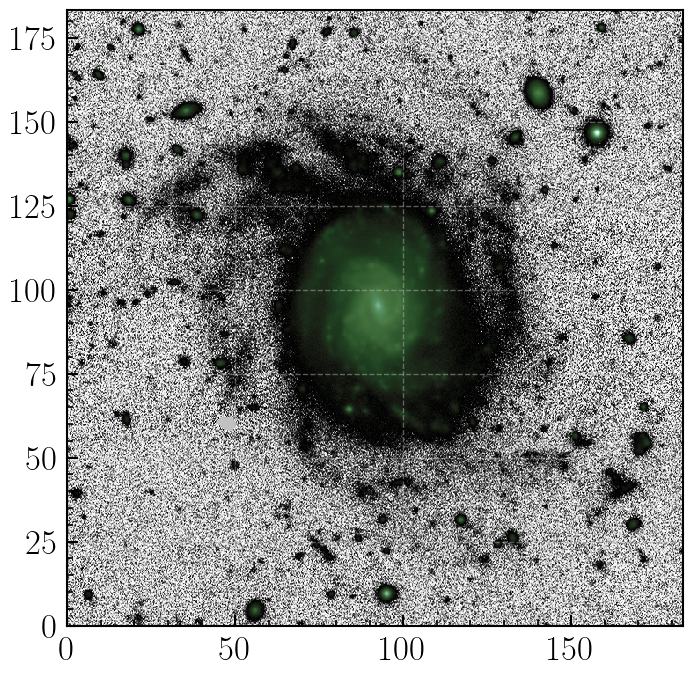

In [4]:
# first let's download an image to play with
hdu = fits.open("https://www.legacysurvey.org/viewer/fits-cutout?ra=36.3684&dec=-25.6389&size=700&layer=ls-dr9&pixscale=0.262&bands=r")
target_data = np.array(hdu[0].data, dtype = np.float64)

# Create a target object with specified pixelscale and zeropoint
target = ap.image.Target_Image(
    data = target_data,
    pixelscale = 0.262, # Every target image needs to know it's pixelscale in arcsec/pixel
    zeropoint = 22.5, # optionally, you can give a zeropoint to tell AutoProf what the pixel flux units are
)

# The default AutoProf target plotting method uses log scaling in bright areas and histogram scaling in faint areas
fig3, ax3 = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig3, ax3, target)
plt.show()

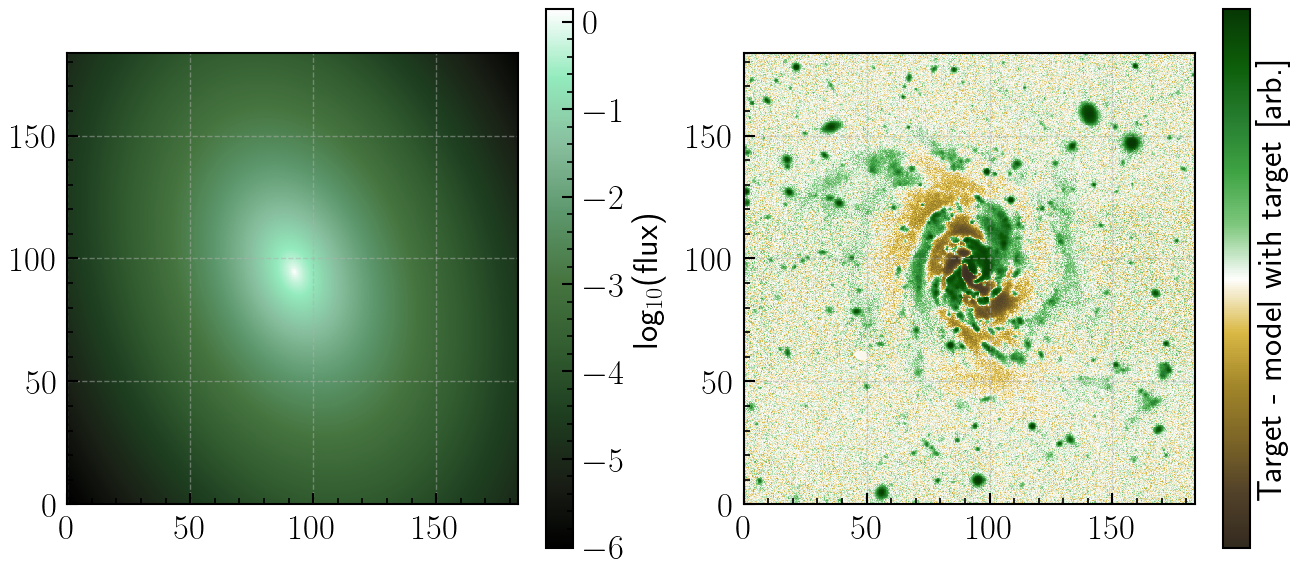

In [5]:
# This model now has a target that it will attempt to match
model2 = ap.models.AutoProf_Model(
    name = "model with target", 
    model_type = "sersic galaxy model", # feel free to swap out sersic with other profile types
    target = target, # now the model knows what its trying to match
)

# Instead of giving initial values for all the parameters, it is possible to simply call "initialize" and AutoProf 
# will try to guess initial values for every parameter assuming the galaxy is roughly centered. It is also possible
# to set just a few parameters and let AutoProf try to figure out the rest. For example you could give it an initial
# Guess for the center and it will work from there.
model2.initialize()

# Plotting the initial parameters and residuals, we see it gets the rough shape of the galaxy right, but still has some fitting to do
fig4, ax4 = plt.subplots(1, 2, figsize = (16,7))
ap.plots.model_image(fig4, ax4[0], model2)
ap.plots.residual_image(fig4, ax4[1], model2)
plt.show()

In [6]:
# Now that the model has been set up with a target and initialized with parameter values, it is time to fit the image
result = ap.fit.LM(model2, verbose = 1).fit()

# See that we use ap.fit.LM, this is the Levenberg-Marquardt Chi^2 minimization method, it is the recommended technique
# for most least-squares problems. However, there are situations in which different optimizers may be more desireable
# so the ap.fit package includes a few options to pick from. The various fitting methods will be described in a 
# different tutorial.
print("Fit message:",result.message) # the fitter will return a message about its convergence

L: 1.0
---------init---------
L: 1.0
---------iter---------
LM loss: 0.00432742833085403
accept
L: 0.1111111111111111
---------iter---------
LM loss: 0.00431714233499777
accept
L: 0.012345679012345678
---------iter---------
LM loss: 0.004314067319419205
accept
L: 0.0013717421124828531
---------iter---------
LM loss: 0.004312945694264768
accept
L: 0.00015241579027587256
---------iter---------
LM loss: 0.004312859323993813
accept
L: 1.6935087808430286e-05
---------iter---------
LM loss: 0.00431285728810506
accept
Fit message: success


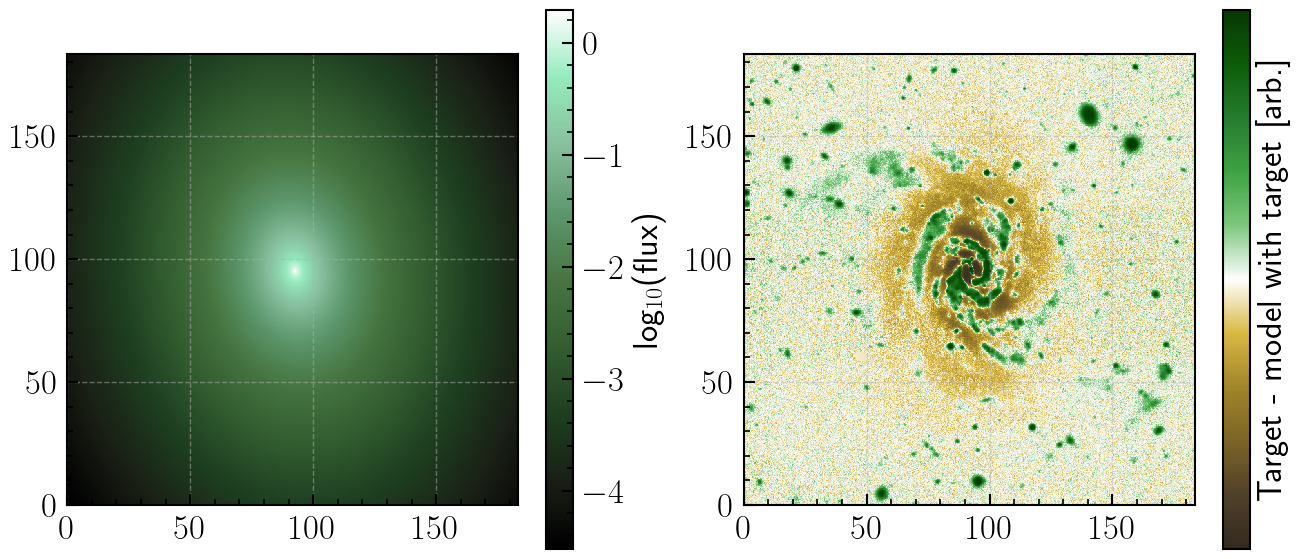

In [7]:
# we now plot the fitted model and the image residuals
fig5, ax5 = plt.subplots(1, 2, figsize = (16,7))
ap.plots.model_image(fig5, ax5[0], model2)
ap.plots.residual_image(fig5, ax5[1], model2)
plt.show()

## Giving the model a specific target window

Sometimes an object isn't nicely centered in the image, and may not even be the dominant object in the image. It is therefore nice to be able to specify what part of the image we should analyze.

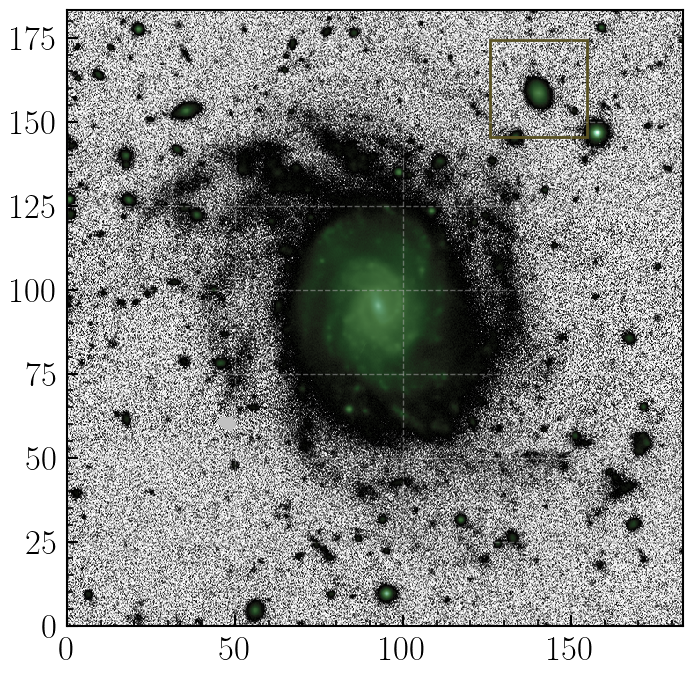

In [8]:
model3 = ap.models.AutoProf_Model(
    name = "model with target", 
    model_type = "sersic galaxy model",
    target = target,
    window = [[480, 590],[555, 665]], # this is a region in pixel coordinates ((xmin,xmax),(ymin,ymax)) 
)

# We can plot the "model window" to show us what part of the image will be analyzed by that model
fig6, ax6 = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig6, ax6, model3.target)
ap.plots.model_window(fig6, ax6, model3)
plt.show()

In [9]:
model3.initialize()
result = ap.fit.LM(model3, verbose = 1).fit()
print(result.message)

L: 1.0
---------init---------
L: 1.0
---------iter---------
LM loss: 5.212348254306662e-05
accept
L: 0.1111111111111111
---------iter---------
LM loss: 3.7790724342854234e-05
accept
L: 0.012345679012345678
---------iter---------
LM loss: 3.7041722207685684e-05
accept
L: 0.0013717421124828531
---------iter---------
LM loss: 3.701037555645408e-05
accept
L: 0.00015241579027587256
---------iter---------
LM loss: 3.701007885748244e-05
accept
L: 1.6935087808430286e-05
---------iter---------
LM loss: 3.7010076913044055e-05
accept
success


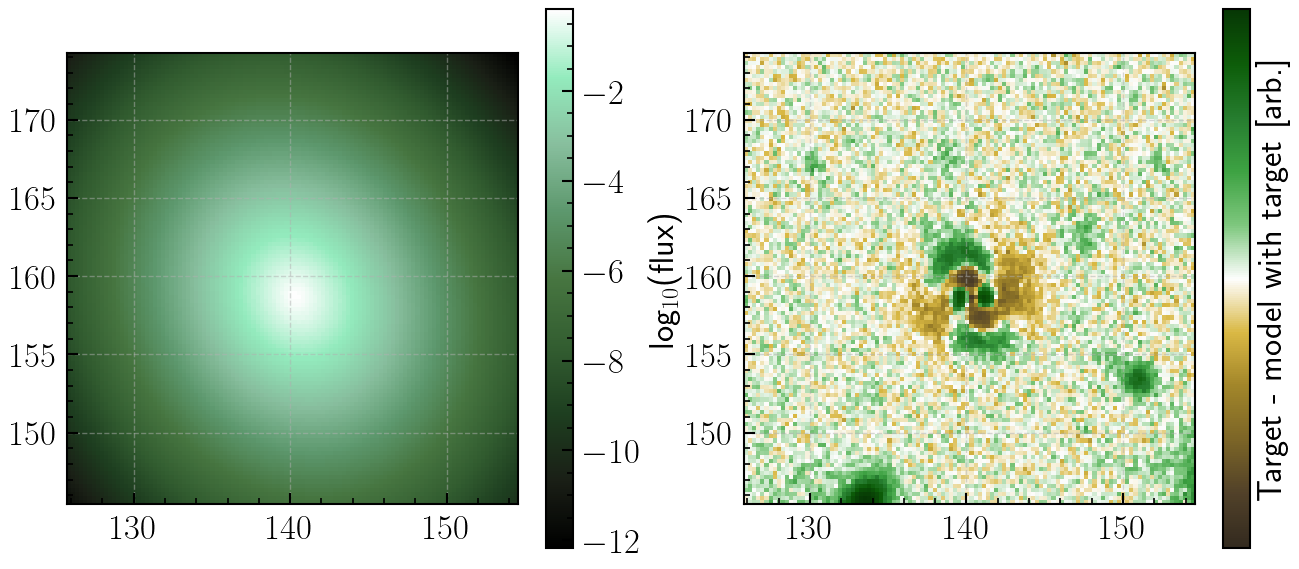

In [10]:
# Note that when only a window is fit, the default plotting methods will only show that window
fig7, ax7 = plt.subplots(1, 2, figsize = (16,7))
ap.plots.model_image(fig7, ax7[0], model3)
ap.plots.residual_image(fig7, ax7[1], model3)
plt.show()

## Setting parameter constraints

A common feature of fitting parameters is that they have some constraint on their behaviour and cannot be sampled at any value from (-inf, inf). AutoProf circumvents this by remapping any constrained parameter to a space where it can take any real value, at least for the sake of fitting. For most parameters these constraints are applied by default; for example the axis ratio q is required to be in the range (0,1). Other parameters, such as the position angle (PA) are cyclic, they can be in the range (0,pi) but also can wrap around. It is possible to manually set these constraints while constructing a model.

In general adding constraints makes fitting more difficult. There is a chance that the fitting process runs up against a constraint boundary and gets stuck. However, sometimes adding constraints is necessary and so the capability is included.

In [11]:
# here we make a sersic model that can only have q and n in a narrow range
# Also, we give PA and initial value and lock that so it does not change during fitting
constrained_param_model = ap.models.AutoProf_Model(
    name = "constrained parameters", model_type = "sersic galaxy model", 
    parameters = {
        "q": {"limits": [0.4,0.6]}, 
        "n": {"limits": [2,3]}, 
        "PA": {"value": 60*np.pi/180, "locked": True},
    }
)

Aside from constraints on an individual parameter, it is sometimes desireable to have different models share parameter values. For example you may wish to combine multiple simple models into a more complex model (more on that in a different tutorial), and you may wish for them all to have the same center. This can be accomplished with "equality constraints" as shown below.

In [12]:
# model 1 is a sersic model
model_1 = ap.models.AutoProf_Model(
    name = "constrained 1",
    model_type = "sersic galaxy model",
    parameters = {"center": [50,50], "PA": np.pi/4}
)
# model 2 is an exponential model
model_2 = ap.models.AutoProf_Model(
    name = "constrained 2",
    model_type = "exponential galaxy model",
)

# Here we add the constraint for "PA" to be the same for each model.
# In doing so we provide the model and parameter name which should 
# be connected.
model_2.add_equality_constraint(model_1, "PA")

# Here we can see how the two models now both can modify this parameter
print("initial values: model_1 PA", model_1["PA"].value.item(), "model_2 PA", model_2["PA"].value.item())
# Now we modify the PA for model_1
model_1["PA"].value = np.pi/3
print("change model_1: model_1 PA", model_1["PA"].value.item(), "model_2 PA", model_2["PA"].value.item())
# Similarly we modify the PA for model_2
model_2["PA"].value = np.pi/2
print("change model_2: model_1 PA", model_1["PA"].value.item(), "model_2 PA", model_2["PA"].value.item())

initial values: model_1 PA 0.7853981852531433 model_2 PA 0.7853981852531433
change model_1: model_1 PA 1.0471975803375244 model_2 PA 1.0471975803375244
change model_2: model_1 PA 1.5707963705062866 model_2 PA 1.5707963705062866


In [13]:
# Keep in mind that both models have full control over the parameter, it is listed in both of
# their "parameter_order" tuples. The built-in AutoProf functions keep track of constrained 
# parameters by asking models if any of their parameters are constrained
print("model_1 parameters: ", model_1.parameter_order(), " are any parameter constrained: ", model_1.equality_constraints)
print("model_2 parameters: ", model_2.parameter_order(), " are any parameter constrained: ", model_2.equality_constraints)

model_1 parameters:  ('center', 'q', 'PA', 'n', 'Re', 'Ie')  are any parameter constrained:  ['PA']
model_2 parameters:  ('center', 'q', 'PA', 'Re', 'Ie')  are any parameter constrained:  ['PA']


## PSF convolution

An important part of astronomical image analysis is accounting for PSF effects. To that end, AutoProf includes a number of approaches to handle PSF convolution. The main concept is that AutoProf will convolve its model with a PSF before comparing against an image. The PSF behaviour of a model is determined by the *psf_mode* parameter which can be set before fitting.

psf mode:  full


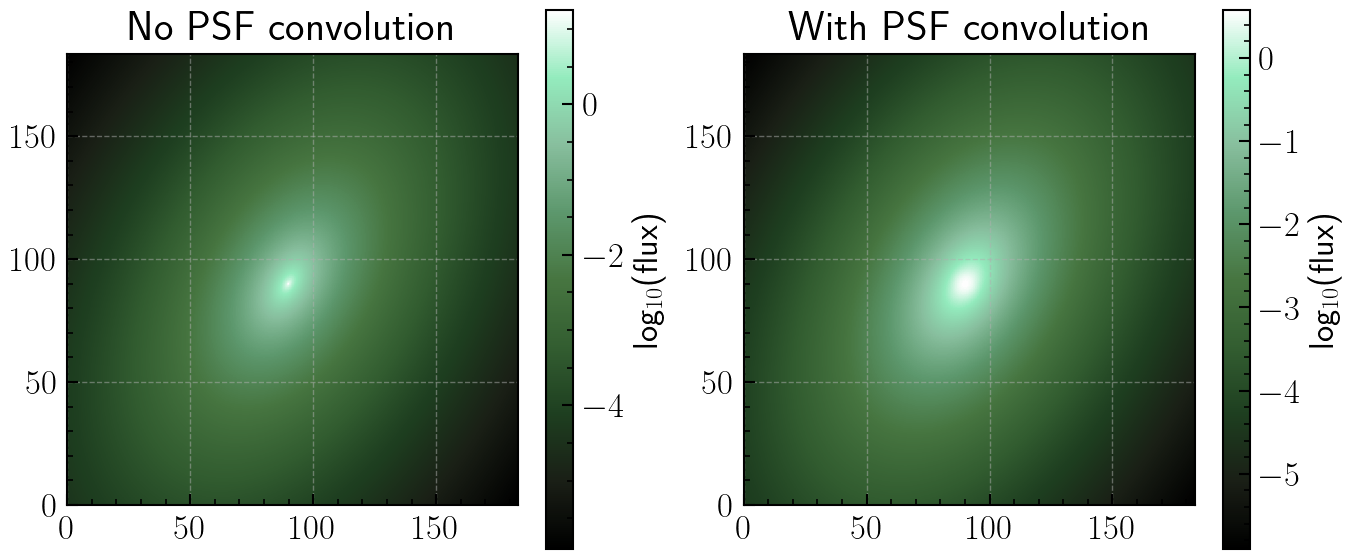

In [14]:
# first a psf is needed, this is stored with the target object
# Here we simply construct a gaussian PSF image that is 31 pixels across
# Note the PSF must always be odd in its dimensions
xx, yy = np.meshgrid(np.linspace(-5,5,31), np.linspace(-5,5,31))
PSF = np.exp(-(xx**2 + yy**2)/5**2)
PSF /= np.sum(PSF)
target = ap.image.Target_Image(
    data = target_data,
    pixelscale = 0.262,
    zeropoint = 22.5,
    psf = PSF,
)

model_nopsf = ap.models.AutoProf_Model(
    name = "model without psf", 
    model_type = "sersic galaxy model",
    target = target,
    parameters = {"center": [90,90], "q": 0.6, "PA": 60*np.pi/180, "n": 2, "Re": 10, "Ie": 1},
    psf_mode = "none", # no PSF convolution will be done
)

model_psf = ap.models.AutoProf_Model(
    name = "model with psf", 
    model_type = "sersic galaxy model",
    target = target,
    parameters = {"center": [90,90], "q": 0.6, "PA": 60*np.pi/180, "n": 2, "Re": 10, "Ie": 1},
    psf_mode = "full", # now the full window will be PSF convolved
)
print("psf mode: ", model_psf.psf_mode)

# With a convolved sersic the center is much more smoothed out
fig, ax = plt.subplots(1,2, figsize = (16,7))
ap.plots.model_image(fig, ax[0], model_nopsf)
ax[0].set_title("No PSF convolution")
ap.plots.model_image(fig, ax[1], model_psf)
ax[1].set_title("With PSF convolution")
plt.show()

## Basic things to do with a model

Now that we know how to create a model and fit it to an image, lets get to know the model a bit better.

In [15]:
# Save the model to a file

model2.save() # will default to save as AutoProf.yaml
with open("AutoProf.yaml", "r") as f:
    print(f.read()) # show what the saved file looks like

model_type: sersic galaxy model
name: model with target
parameters:
  Ie:
    name: Ie
    uncertainty: 0.1227574869049998
    units: log10(flux/arcsec^2)
    value: 0.12114503451194084
  PA:
    cyclic: true
    limits: !!python/tuple
    - 0
    - 3.141592653589793
    name: PA
    uncertainty: 0.19192554240755721
    units: radians
    value: 1.7096962229848938
  Re:
    limits: !!python/tuple
    - 0
    - null
    name: Re
    uncertainty: 3.178048287131556
    units: arcsec
    value: 17.270411694409677
  center:
    name: center
    uncertainty:
    - 0.19463782391737522
    - 0.2698382823511597
    units: arcsec
    value:
    - 92.75355088720687
    - 95.230126766753
  n:
    limits: !!python/tuple
    - 0.36
    - 8
    name: n
    uncertainty: 0.26548222826853124
    units: none
    value: 1.8389426743785622
  q:
    limits: !!python/tuple
    - 0
    - 1
    name: q
    uncertainty: 0.08641708083482062
    units: b/a
    value: 0.7414627346698237
window:
  origin: !!python/

In [16]:
# load a model from a file

# note that the target still must be specified, only the parameters are saved
model4 = ap.models.AutoProf_Model(
    name="no name", 
    filename="AutoProf.yaml", 
    target=target)

print(model4) # can see that it has been constructed with all the same parameters as the saved model2.

name: model with target
model_type: sersic galaxy model
window: {'origin': (0.0, 0.0), 'shape': (183.4, 183.4)}
parameters: {'center': {'name': 'center', 'value': [92.75355088720687, 95.230126766753], 'units': 'arcsec', 'uncertainty': [0.19463782391737522, 0.2698382823511597]}, 'q': {'name': 'q', 'value': 0.7414627346698237, 'units': 'b/a', 'uncertainty': 0.08641708083482062, 'limits': (0, 1)}, 'PA': {'name': 'PA', 'value': 1.7096961736679077, 'units': 'radians', 'uncertainty': 0.19192554240755721, 'limits': (0, 3.141592653589793), 'cyclic': True}, 'n': {'name': 'n', 'value': 1.8389426743785622, 'units': 'none', 'uncertainty': 0.26548222826853124, 'limits': (0.36, 8)}, 'Re': {'name': 'Re', 'value': 17.270411694409677, 'units': 'arcsec', 'uncertainty': 3.178048287131556, 'limits': (0, None)}, 'Ie': {'name': 'Ie', 'value': 0.12114503451194084, 'units': 'log10(flux/arcsec^2)', 'uncertainty': 0.1227574869049998}}



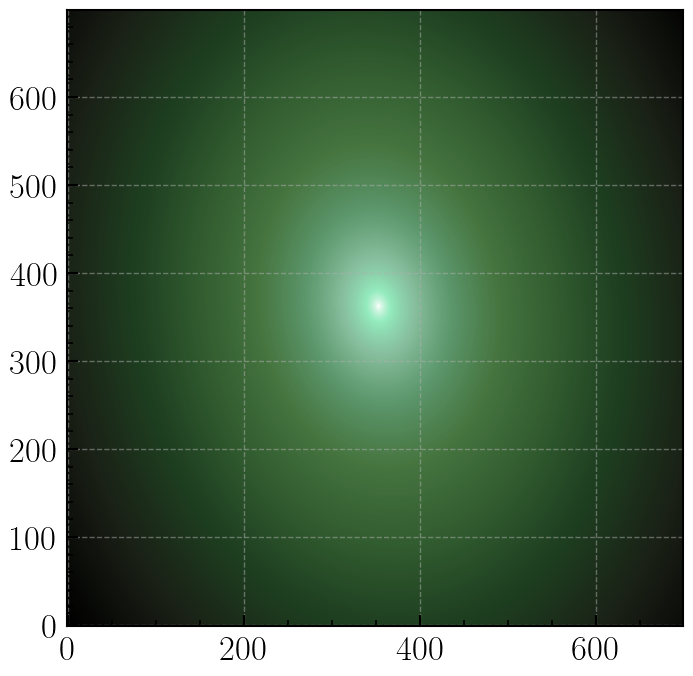

In [17]:
# Save the model image to a file

model2().save("model2.fits")

saved_image_hdu = fits.open("model2.fits")
fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(
    np.log10(saved_image_hdu[0].data), 
    origin = "lower",
    cmap = ap.plots.visuals.cmap_grad, # gradient colourmap default for AutoProf
)
plt.show()

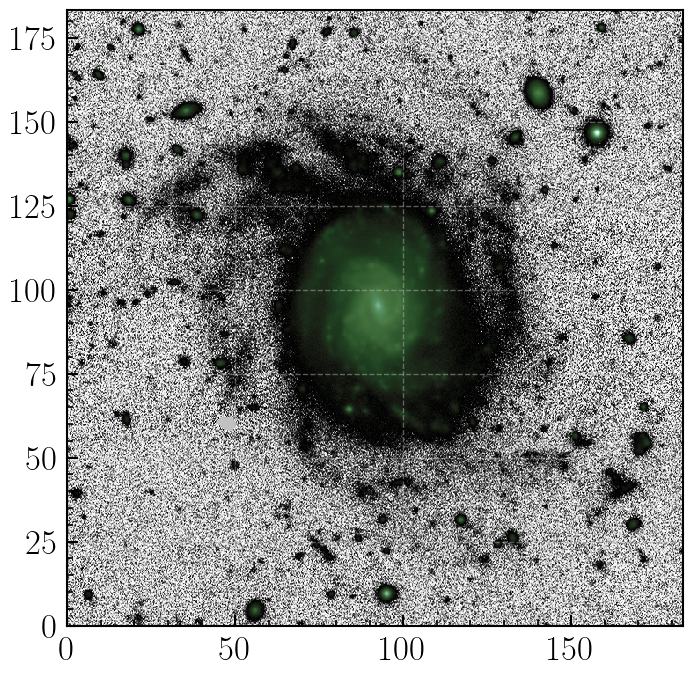

In [18]:
# Save and load a target image

target.save("target.fits")

new_target = ap.image.Target_Image(filename = "target.fits")

fig, ax = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig, ax, new_target)
plt.show()

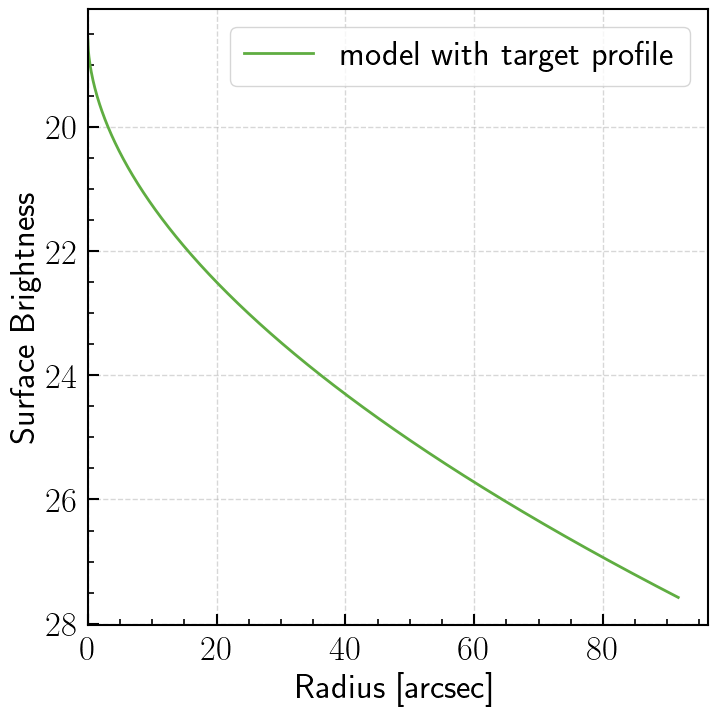

In [19]:
# Plot the surface brightness profile

fig8, ax8 = plt.subplots(figsize = (8,8))
ap.plots.galaxy_light_profile(fig8, ax8, model4)
plt.legend()
plt.show()

In [20]:
# Give the model new parameter values manually

print("parameter input order: ", 
      model4.parameter_order()) 
# use this to see what order you have to give the parameters as input

parameter input order:  ('center', 'q', 'PA', 'n', 'Re', 'Ie')


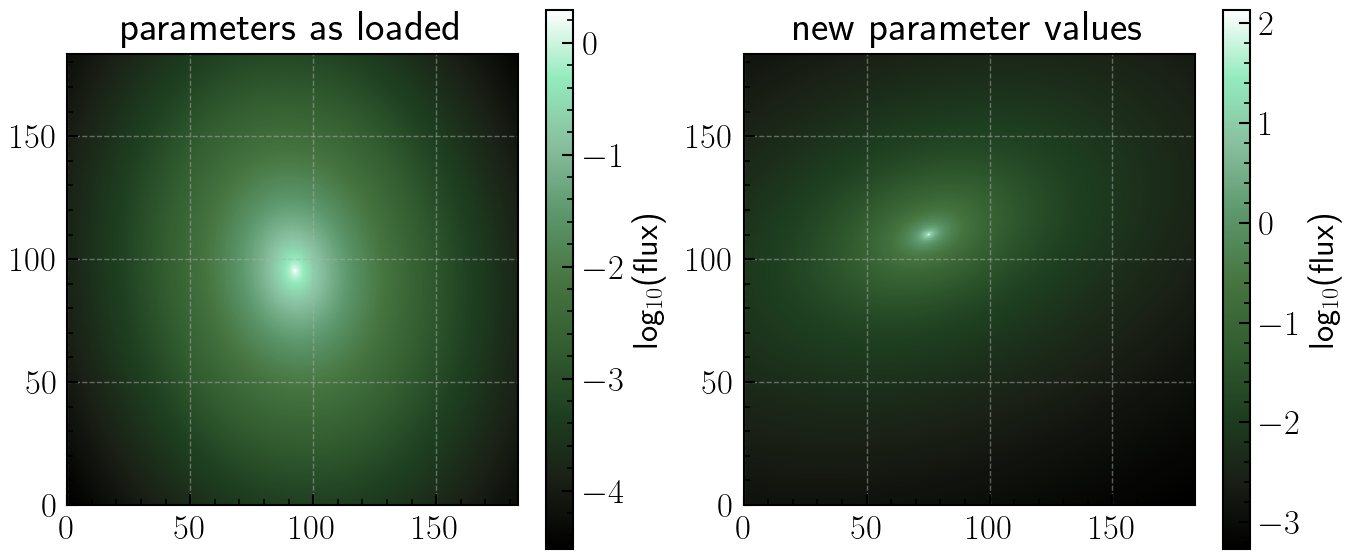

In [21]:
# plot the old model
fig9, ax9 = plt.subplots(1,2,figsize = (16,7))
ap.plots.model_image(fig9, ax9[0], model4)
T = ax9[0].set_title("parameters as loaded")

# update and plot the new parameters
new_parameters = torch.tensor(
    [75, 110, 0.4, 20 * np.pi / 180, 3, 25, 0.12]) 
# note that the center parameter needs two values as input

# initialize must be called before optimization, or any other activity in which parameters are updated
model4.initialize() 

# full_sample will update the parameters, then run sample and return the model image 
model4.set_parameters(new_parameters) 

ap.plots.model_image(fig9, ax9[1], model4)
T = ax9[1].set_title("new parameter values")

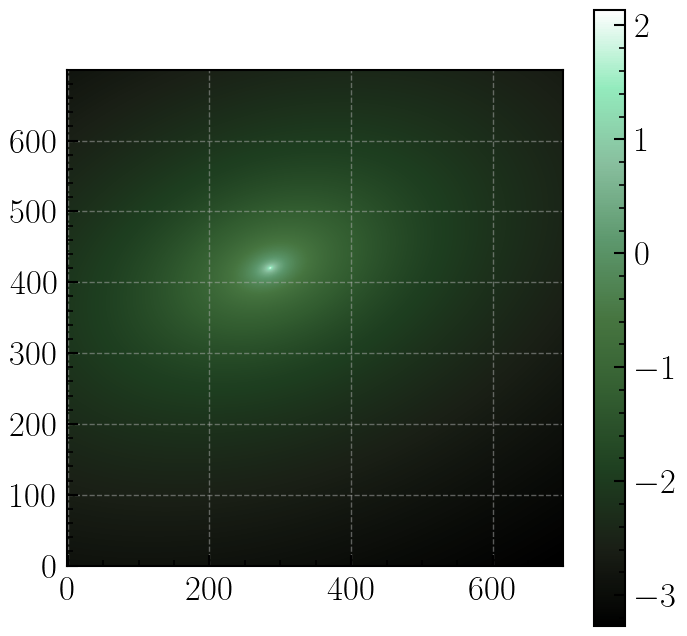

In [22]:
# Access the model image pixels directly

fig2, ax2 = plt.subplots(figsize = (8,8))

# model4.model_image.data is the pytorch stored model image pixel values. Calling detach().cpu().numpy() is needed to get the data out of pytorch and in a usable form
pixels = model4().data.detach().cpu().numpy()

im = plt.imshow(
    np.log10(pixels), # take log10 for better dynamic range
    origin = "lower",
    cmap = ap.plots.visuals.cmap_grad, # gradient colourmap default for AutoProf
)
plt.colorbar(im)
plt.show()

In [23]:
# Models can be constructed by providing model_type, 
# or by creating the desired class directly 
# Notice this is no longer "AutoProf_Model"

model1_v2 = ap.models.Sersic_Galaxy(
    name="model1 v2",
    parameters={
        "center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "n": 2, "Re": 10, "Ie": 1},
    target = ap.image.Target_Image(np.zeros((100,100)), pixelscale = 1),
)

# This will be the same as model1
print(model1_v2)

name: model1 v2
model_type: sersic galaxy model
window: {'origin': (0.0, 0.0), 'shape': (100.0, 100.0)}
parameters: {'center': {'name': 'center', 'value': [50.0, 50.0], 'units': 'arcsec', 'uncertainty': 0.1}, 'q': {'name': 'q', 'value': 0.6, 'units': 'b/a', 'uncertainty': 0.03, 'limits': (0, 1)}, 'PA': {'name': 'PA', 'value': 1.0471975803375244, 'units': 'radians', 'uncertainty': 0.06, 'limits': (0, 3.141592653589793), 'cyclic': True}, 'n': {'name': 'n', 'value': 2.0, 'units': 'none', 'uncertainty': 0.05, 'limits': (0.36, 8)}, 'Re': {'name': 'Re', 'value': 10.0, 'units': 'arcsec', 'limits': (0, None)}, 'Ie': {'name': 'Ie', 'value': 1.0, 'units': 'log10(flux/arcsec^2)'}}



In [24]:
# List all the available model names

# AutoProf keeps track of all the subclasses of the AutoProf_Model object, this list will 
# include all models even ones added by the user
print(ap.models.AutoProf_Model.List_Model_Names(useable = True)) # set useable = None for all models, or useable = False for only base classes
print("---------------------------")

# It is also possible to get all sub models of a specific Type
print("only star models: ", ap.models.Star_Model.List_Model_Names())

['isothermal sech2 edgeon model', 'group model', 'nonparametric star model', 'sersic star model', 'psf star model', 'exponential star model', 'gaussian star model', 'nuker star model', 'moffat star model', 'plane sky model', 'flat sky model', 'nonparametric galaxy model', 'sersic galaxy model', 'nonparametric wedge galaxy model', 'sersic wedge galaxy model', 'exponential wedge galaxy model', 'gaussian wedge galaxy model', 'nuker wedge galaxy model', 'nonparametric superellipse galaxy model', 'sersic superellipse galaxy model', 'exponential superellipse galaxy model', 'gaussian superellipse galaxy model', 'nuker superellipse galaxy model', 'exponential galaxy model', 'gaussian galaxy model', 'nonparametric warp galaxy model', 'sersic warp galaxy model', 'nonparametric superellipse warp galaxy model', 'sersic superellipse warp galaxy model', 'exponential superellipse warp galaxy model', 'gaussian superellipse warp galaxy model', 'nuker superellipse warp galaxy model', 'exponential warp g

- 1-D profile model
    - "nonparametric fourier galaxy model"
    - "nonparametric fourier warp galaxy model"

## Using GPU acceleration

This one is easy! If you have a cuda enabled GPU available, AutoProf will just automatically detect it and use that device. 

In [27]:
# check if AutoProf has detected your GPU

# most likely this will say "cpu" unless you already have a cuda GPU, in which case it should say "cuda:0"
print(ap.AP_config.ap_device) 

cpu


In [28]:
# If you have a GPU but want to use the cpu for some reason, just set:
ap.AP_config.ap_device = "cpu"
# BEFORE creating anything else (models, images, etc.)

## Boost GPU acceleration with single precision float32

If you are using a GPU you can get significant performance increases in both memory and speed by switching from double precision (the AutoProf default) to single precision floating point numbers. The trade off is reduced prcision, this can cause some unexpected behaviors. For example an optimizer may keep iterating forever if it is trying to optimize down to a precision below what the float32 will track. Typically, numbers with float32 are good down to 6 places and AutoProf by default only attempts to minimize the Chi^2 to 3 places. However, to ensure the fit is secure to 3 places it often checks what is happenening down at 4 or 5 places. Hence, issues can arise. For the most part you can go ahead with float32 and if you run into a weird bug, try on float64 before looking further.

In [29]:
# Again do this BEFORE creating anything else
ap.AP_config.ap_dtype = torch.float32

# Now new AutoProf objects will be made with single bit precision
W1 = ap.image.Window(origin = [0,0], shape = [1,1])
print("now a single:", W1.origin.dtype)

# Here we switch back to double precision
ap.AP_config.ap_dtype = torch.float64
W2 = ap.image.Window(origin = [0,0], shape = [1,1])
print("back to double:", W2.origin.dtype)
print("old window is still single:", W1.origin.dtype)

now a single: torch.float32
back to double: torch.float64
old window is still single: torch.float32


See how the window created as a float32 stays that way? That's really bad to have lying around! Make sure to change the data type before creating anything! 

## Tracking output

The AutoProf optimizers, and ocasionally the other AutoProf objects, will provide status updates about themselves which can be very useful for debugging problems or just keeping tabs on progress. There are a number of use cases for AutoProf, each having different desired output behaviors. To accomodate all users, AutoProf implements a general logging system. The object `ap.AP_config.ap_logger` is a logging object which by default writes to AutoProf.log in the local directory. As the user, you can set that logger to be any logging object you like for arbitrary complexity. Most users will, however, simply want to control the filename, or have it output to screen instead of a file. Below you can see examples of how to do that.

In [30]:
# note that the log file will be where these tutorial notebooks are in your filesystem

# Here we change the settings so AutoProf only prints to a log file
ap.AP_config.set_logging_output(stdout = False, filename = "AutoProf.log")
ap.AP_config.ap_logger.info("message 1: this should only appear in the AutoProf log file")

# Here we change the settings so AutoProf only prints to console
ap.AP_config.set_logging_output(stdout = True, filename = None)
ap.AP_config.ap_logger.info("message 2: this should only print to the console")

# Here we change the settings so AutoProf prints to both, which is the default
ap.AP_config.set_logging_output(stdout = True, filename = "AutoProf.log")
ap.AP_config.ap_logger.info("message 3: this should appear in both the console and the log file")

message 2: this should only print to the console
message 3: this should appear in both the console and the log file


You can also change the logging level and/or formatter for the stdout and filename options (see `help(ap.AP_config.set_logging_output)` for details). However, at that point you may want to simply make your own logger object and assign it to the `ap.AP_config.ap_logger` variable.